In [1]:
import os
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict, namedtuple
from io import StringIO
import re
from IPython.display import display, Latex

## reading results

In [113]:
def group_files(res_path):
    # group file names by configuration
    results_by_specs = defaultdict(list)
    for fname in os.listdir(res_path):
        if not fname.endswith('.txt'):
            continue

        try:
            spec, day, hour = fname[:-len('.txt')].split('-')
            
            if 'MOSTEstimator' in fname:
                _, model, most, cvk = spec.split('_')
                features = 'zL'
                trend = '-'
            else:
                _, model, features, trend, most, cvk = spec.split('_')
        except:
            print('bad name:', fname)
            continue

        results_by_specs[(model, features, trend, most, cvk)].append(fname)

    spec_cols = ['estimator', 'features', 'trend', 'most', 'cvk']
        
    return results_by_specs, spec_cols


def parse_result_file(res_path, res_file, section_name):
    res_lines, found = [], False
    with open(os.path.join(res_path, res_file)) as f:
        for i, row in enumerate(f):
            rr = row.strip()

            if found and not rr.startswith('**'):
                res_lines.append(rr)
            elif found and rr.startswith('**'):
                break
            elif not found and rr.startswith('**' + section_name):
                found = True

    if not found:
        raise RuntimeError('section %s not found in file %s' % (section_name, res_file))
    elif not res_lines:
        raise RuntimeError('section %s is empty in file %s' % (section_name, res_file))

    csv_text = re.sub('[ \t]+', ',', '\n'.join(res_lines))
    section_df = pd.read_csv(StringIO(csv_text))

    rows =[
        [i, col, val]
        for col in section_df
        for i, val in enumerate(section_df[col])
    ]
    
    cols = ['trial', 'column', 'value']
        
    return rows, cols

def get_results(res_path, section_name):
    results_by_specs, spec_cols = group_files(res_path)
    
    df_rows, df_cols = [], None
    for spec, files in results_by_specs.items():
        latest_fname = list(sorted(files))[-1]
        for fname in files:
            rows, cols = parse_result_file(res_path, fname, section_name)
            
            df_rows.extend([
                list(spec) + rr + [fname == latest_fname]
                for rr in rows
            ])
            cols = spec_cols + cols + ['is_latest']
            
            if not df_cols:
                df_cols = cols
            else:
                assert df_cols == cols

    results = pd.DataFrame(df_rows, columns=df_cols)
    return results


long_to_short_metric = {
    'mean_squared_error': 'MSE',
    'median_squared_error': 'mSE',
    'mean_absolute_error': 'MAE',
    'median_absolute_error': 'mAE',
    'mean_abs_percent_error': 'MAPE',
    'median_abs_percent_error': 'mAPE',
    'r2_score': '$R^2$',
}

res = get_results('dev/results', 'raw scores')

short_to_long_metric = {
    v: k for k, v in long_to_short_metric.items()
}

res = res[
    (res.column != 'explained_variance_score')
].replace({
    'most': {'most': 'MOST', 'nomost': 'Full'},
    'trend': {'trend': 'Y', 'notrend': 'N'},
    'estimator': {
        'KNeighborsRegressor': 'kNN',
        'GradientBoostingRegressor': 'GB',
        'MOSTEstimator': 'MOST',
    },
    'column': long_to_short_metric,
    'features': {'f1': 'F1', 'f2': 'F2', 'f3': 'F3', 'f4': 'F4', 'f5': 'F5'},
}).rename(columns={
    'features': 'Features',
    'column': 'Metric',
    'trend': 'Trend',
    'most': 'Dataset',
    'estimator': 'Model',
})

res.head(5)

,Model,Features,Trend,Dataset,cvk,trial,Metric,value,is_latest
0,GB,F1,N,MOST,0outercv,0,train_mse,0.183077,False
1,GB,F1,N,MOST,0outercv,1,train_mse,0.186880,False
2,GB,F1,N,MOST,0outercv,2,train_mse,0.186505,False
3,GB,F1,N,MOST,0outercv,3,train_mse,0.181897,False
4,GB,F1,N,MOST,0outercv,4,train_mse,0.182580,False


In [96]:
paras = get_results('dev/results', 'raw parameters')
paras.head(5)

,estimator,features,trend,most,cvk,trial,column,value,is_latest
0,GradientBoostingRegressor,f1,notrend,most,0outercv,0,alpha,0.396273,False
1,GradientBoostingRegressor,f1,notrend,most,0outercv,1,alpha,0.396273,False
2,GradientBoostingRegressor,f1,notrend,most,0outercv,2,alpha,0.396273,False
3,GradientBoostingRegressor,f1,notrend,most,0outercv,3,alpha,0.396273,False
4,GradientBoostingRegressor,f1,notrend,most,0outercv,4,alpha,0.396273,False


## generation of charts

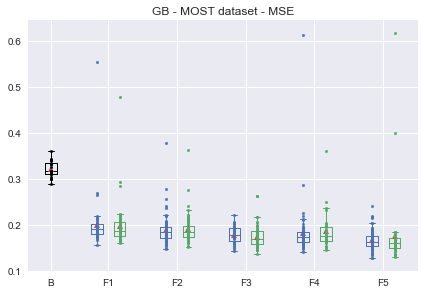

In [114]:
def paint_boxplot(bplot, all_color=None, **kwargs):
    # use all_color to paing all elements of the same color
    # or specify color for each element in kwargs
    # kwargs take precedence over all_color
    #
    # NB available elements are
    # boxes, medians, whiskers, caps, fliers, means

    for key in bplot:
        color = kwargs.get(key, all_color)
        if color:
            for element in bplot[key]:
                element.set_color(color)


def make_base_plot(res, model, dataset, metric, save_path=None, plot_all=True,
                   show_legend=False, show_baseline=True):
    
    plot_data, found = [], False
    fig, ax = plt.subplots()

    for features in range(1, 6):
        for tidx, trend in enumerate(['Y', 'N']):
            vals = res[
                (res.Model == model) &
                (res.Dataset == dataset) &
                (res.Features == 'F%d' % features) &
                (res.Trend == trend) & 
                (res.Metric == metric)
            ]['value'].values

            if vals.size == 0:
                plot_data.append([])
                continue

            if plot_all:
                plt.scatter([3 * (features - 1) + tidx] * len(vals), vals,
                            color='C%d' % tidx, s=7, zorder=10, marker='o')

            plot_data.append(vals)
            found = True

    if not found:
        print('no results for model %s on metric %s with dataset %s' % (
            model, metric, dataset
        ))
        return None, None
    
    boxplot_kwargs = {
        'showmeans': True,
        'patch_artist': False,
        'zorder': 5,
        'showfliers': not plot_all,
    }
    
    # trend
    bp1 = ax.boxplot(plot_data[::2], positions=range(0, 15, 3),
                     sym='C0.', **boxplot_kwargs)
    paint_boxplot(bp1, 'C0')

    # no trend
    bp2 = ax.boxplot(plot_data[1::2], positions=range(1, 15, 3),
                     sym='C1.', **boxplot_kwargs)
    paint_boxplot(bp2, 'C1')

    if show_baseline:
        most_data = res[
            (res.Model == 'MOST') &
            (res.Dataset == dataset) &
            (res.Metric == metric)
        ]

        bpm = ax.boxplot(most_data.value, positions=[-2], sym='k.',
                         widths=[0.5], **boxplot_kwargs)
        paint_boxplot(bpm, 'k')
        
        if plot_all:
            plt.scatter([-2] * len(most_data), most_data.value,
                        color='k', s=7, zorder=10, marker='o')

    if show_legend:
        old_ylim = ax.get_ylim()
        legend_lines = [
            ax.plot([], [], c='C0')[0],
            ax.plot([], [], c='C1')[0],
            ax.plot([], [], c='k')[0],
        ]
        
        ax.legend(legend_lines, ['Trend', 'No Trend', 'MOST'])
        ax.set_ylim(old_ylim)
    
    ax.margins(y=0.05)
    ax.set_xlim(-3, 14)
    ax.set_xticks([-2, 0.5, 3.5, 6.5, 9.5, 12.5])
    ax.set_xticklabels(['B', 'F1', 'F2', 'F3', 'F4', 'F5'])    
    fig.tight_layout()
    
    if save_path is not None:
        most = 'most' if dataset == 'MOST' else 'nomost'
        column = short_to_long_metric[metric]
        fig.savefig(os.path.join(
            save_path, 'result_%s_%s_%s.png' % (
                model, most, column
            )
        ))
    
    # show the title on the notebook but not in the saved figure
    ax.set_title(
        model +
        ' - ' + '%s dataset' % dataset +
        ' - ' + metric
    )

    return fig, ax


plt.show(make_base_plot(res, 'GB', 'MOST', 'MSE')[0])

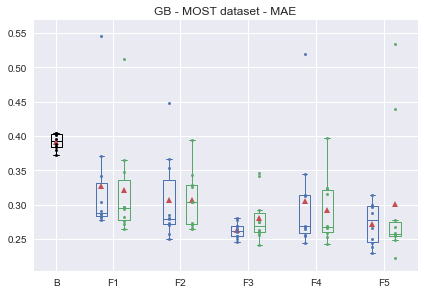

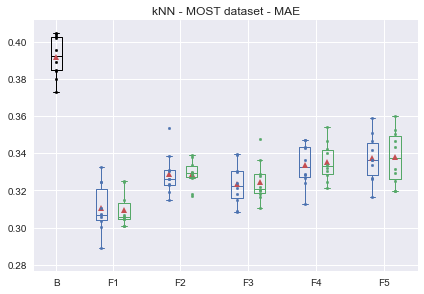

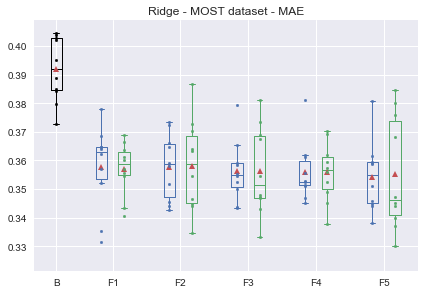

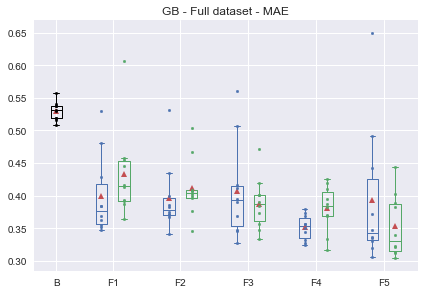

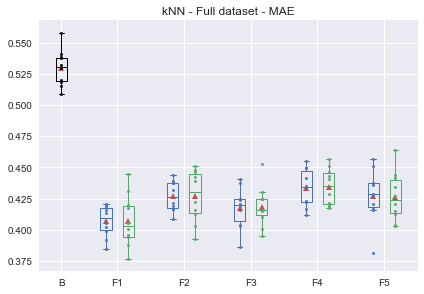

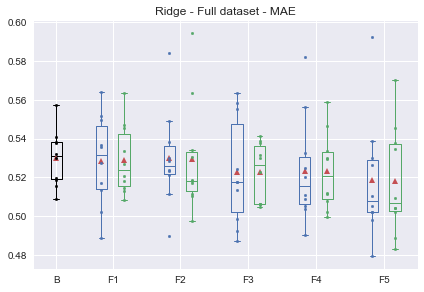

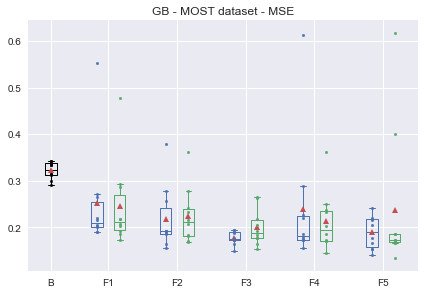

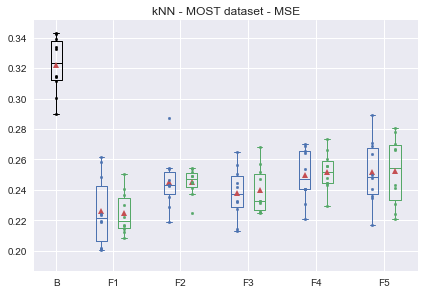

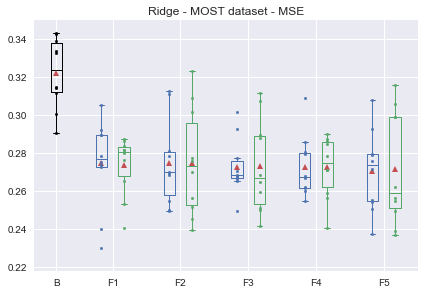

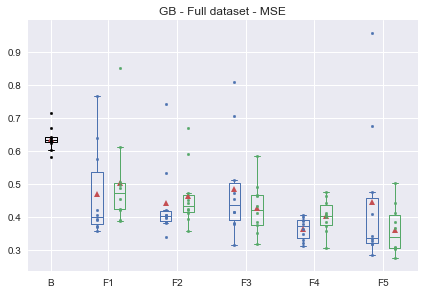

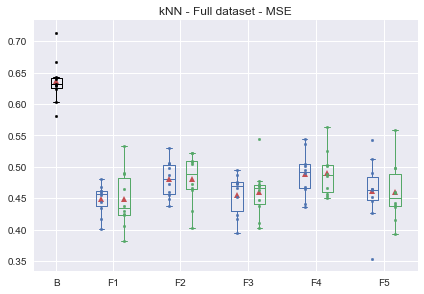

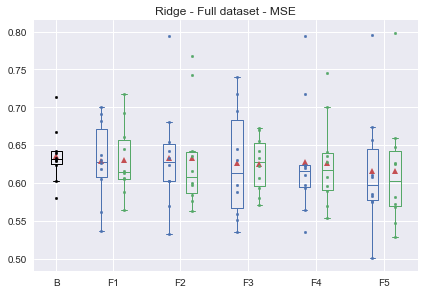

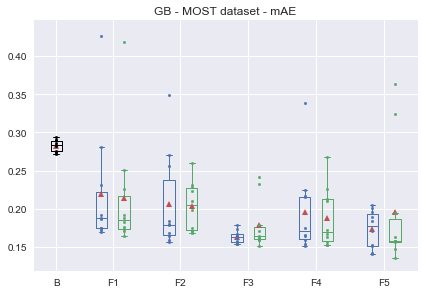

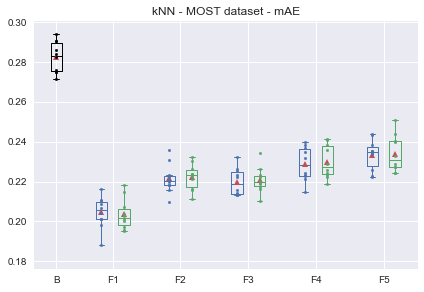

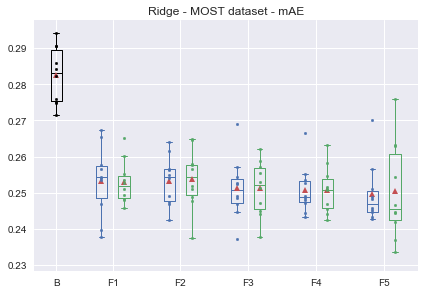

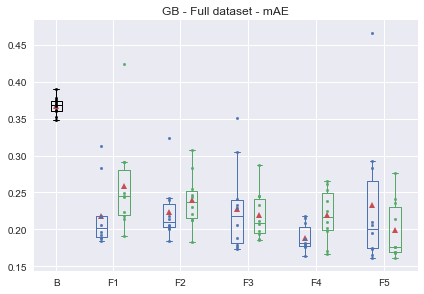

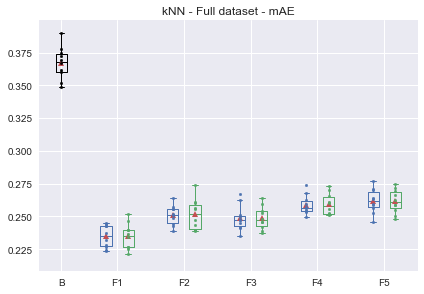

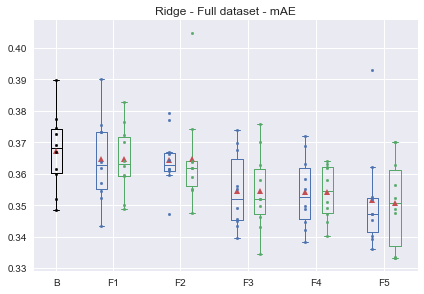

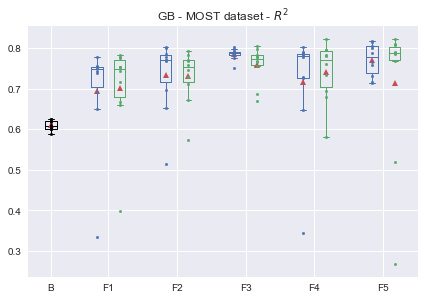

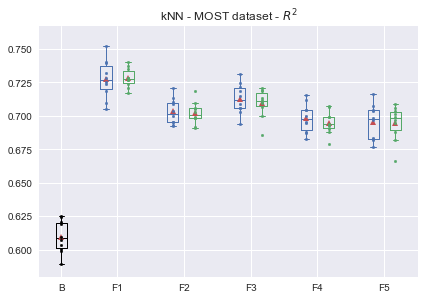

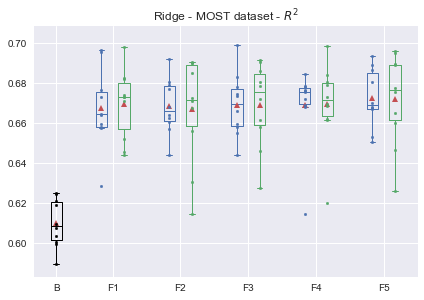

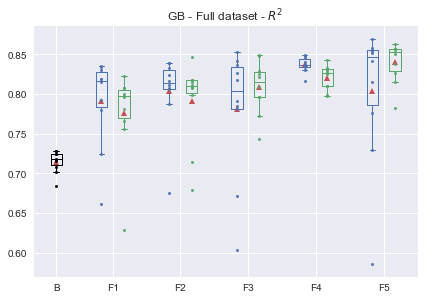

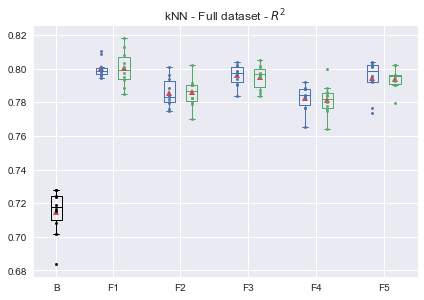

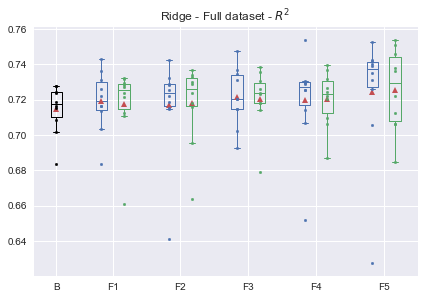

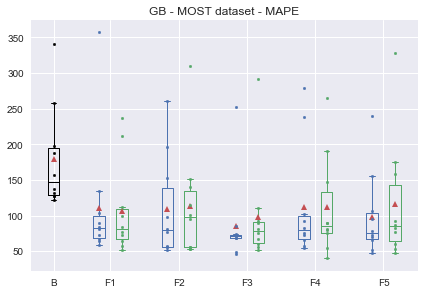

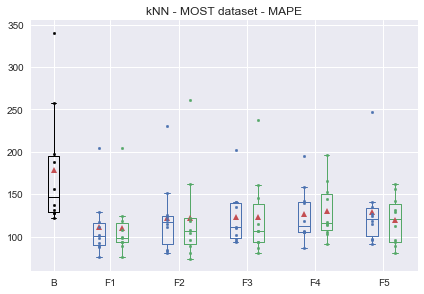

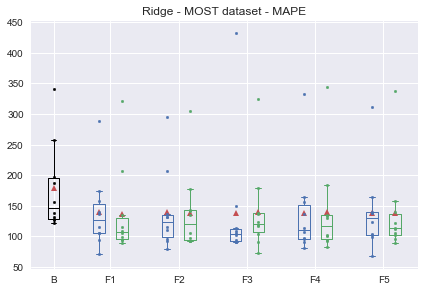

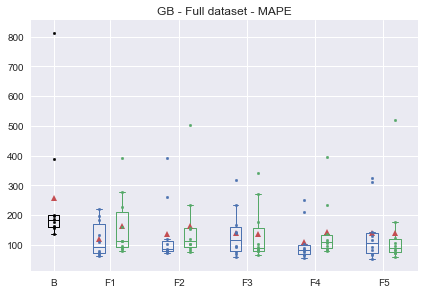

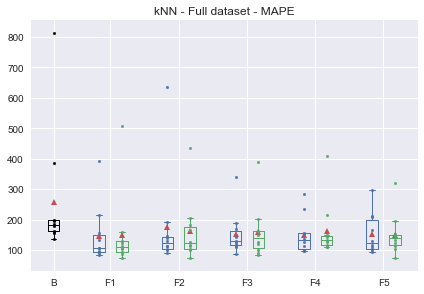

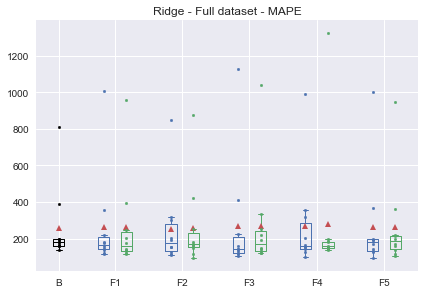

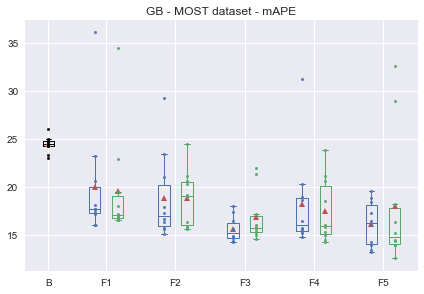

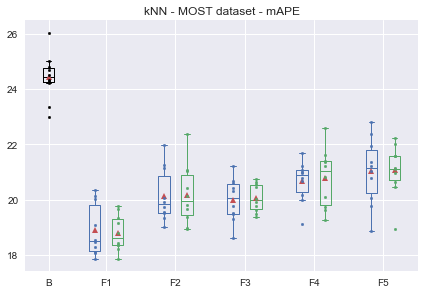

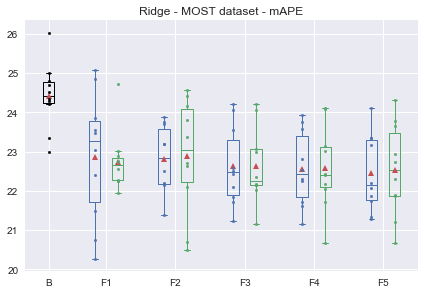

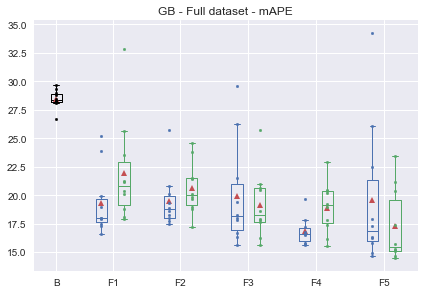

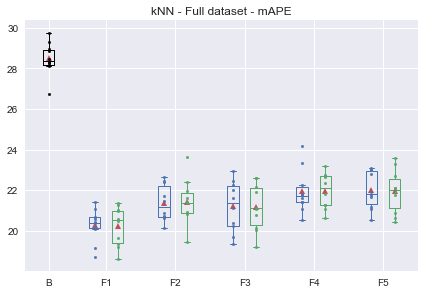

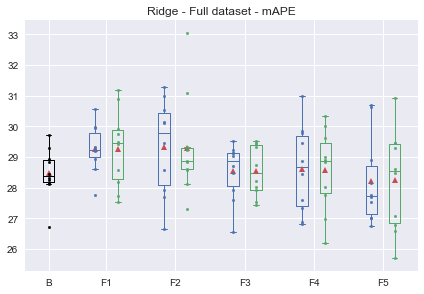

In [119]:
rrr = res[
    (res.cvk == '10outercv') &
    (res.is_latest == True) &
    (res.Metric != 'train_mse') &
    (res.Metric != 'explained_variance_score')
]

for met in rrr.Metric.unique():
    for dataset in ['MOST', 'Full']:
        for mod in ['GB', 'kNN', 'Ridge']:
            plt.show(make_base_plot(rrr, mod, dataset, met, 'manuscript/images')[0])

## preparations for export 

In [148]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)


def table_newline(text):
    return '\makecell[c]{%s}' % text.replace('\n', r'\\')


def latex_bold(s):
    return r'\textbf{%s}' % s


def df_to_latex(df, vertical_space='1ex', column_align='c', fill_page_width=True,
                save_to=None, clear_index_name=True, multirow_pad='0.75ex'):
    
    if clear_index_name:  # otherwise first row will be included in the table header
        df.index.name = ''

    if len(column_align) == 1:
        column_align = column_align * len(df.columns)

    # make bold column names
    df.columns = list(map(latex_bold, df.columns))
        
    latex = '\\centering' + df.to_latex(
        escape=False,
        bold_rows=True,
        column_format='asd' if fill_page_width else column_align,
        multirow=True,
        #index_names=not clear_index_name,
    )

    # replace double clines with a single hline
    latex = re.sub(r'\\cline{.*?}\n\\cline{.*?}', '\hline', latex)

    if vertical_space:
        # add vertical space between cells
        latex = (
            '\setcellgapes{%s}\makegapedcells' % vertical_space
        ) + latex

    if 'makecell' in latex:
        # if we used makecell to insert newlines inside each cell, we have
        # to double the vertical size of the multirows
        # also move column name slightly upwards to make it aligned with center line
        # (move up by 1ex and down by 0.15ex to balance the padding)
        latex = re.sub(r'\\multirow{(\d+)}{\*}{(.*?)}', 
                       lambda m: r'\multirowcell{%d}[%s][c]{%s}' % (2 * int(m[1]), multirow_pad, m[2]),
                       latex)

    if fill_page_width:
        # use tabular* environment to make table fill the page width
        latex = latex.replace(
            r'\begin{tabular}{asd}',
            r'\begin{tabular*}{\textwidth}{%s}' % (
                column_align.replace('|', r'|@{\extracolsep{\fill}}')
            )
        ).replace(r'\end{tabular}', r'\end{tabular*}')
    
    if save_to:
        with open(save_to, 'w') as f:
            f.write(latex)

    return latex

## generation of effect sizes

In [154]:
def compute_effect_size(control, treatment, ci_alpha_left=0.05,
                        ci_alpha_right=None, winsor=0.2,
                        direction=-1, bootstrap_repeats=1000):
    ''' compare treatment to control (normalize by treatment's standard deviation)
    
        use positive direction to have positive effect size
        when mean treatment > mean control, and vice-versa
    '''
    nc, nt = len(control), len(treatment)

    effect_sizes = []
    for i in range(bootstrap_repeats):
        ssc = np.random.choice(control, nc)
        sst = np.random.choice(treatment, nt)
        
        tmc = stats.trim_mean(ssc, winsor)
        tmt = stats.trim_mean(sst, winsor)
        wst = stats.mstats.winsorize(sst, winsor).std()

        #es = np.sign(direction) * (1 - 2 * winsor) * (tmt - tmc) / wst
        larger = count = 0
        for xc in ssc:
            for xt in sst:
                count += 1
                if (direction < 0 and xt > xc) or (direction > 0 and xt < xc):
                    larger += 1
        es = larger / count
        effect_sizes.append(es)

    es_avg = stats.trim_mean(effect_sizes, 0.2)
    
    if ci_alpha_left and 0.0 < ci_alpha_left < 1.0:
        ci_lo = np.percentile(effect_sizes, 100 * ci_alpha_left)
    else:
        ci_lo = -np.inf
    
    if ci_alpha_right and 0.0 < ci_alpha_right < 1.0:
        ci_hi = np.percentile(effect_sizes, 100 * ci_alpha_right)
    else:
        ci_hi = np.inf

    return es_avg, effect_sizes.std()**2, (ci_lo, ci_hi)


def es_to_string(es, ci_lo, ci_hi, float_format='%.2f'):
    ci_left = np.isfinite(ci_lo)
    ci_right = np.isfinite(ci_hi)
    
    if ci_left and ci_right:
        fmt = '{0} [{0}; {0}]'.format(float_format)
        return fmt % (es, ci_lo, ci_hi)
    elif ci_left and not ci_right:
        fmt = '{0}/{0}'.format(float_format)
        return fmt % (ci_lo, es)
    elif not ci_left and ci_right:
        fmt = '{0}/{0}'.format(float_format)
        return fmt % (es, ci_hi)
    else:
        fmt = '%s' % float_format
        return fmt % es

graphical demonstration on why we normalize by the standard deviation of the treatment

In [155]:
def show_effect_size(control, treatment, save_path=None):
    es, _, (cil, cih) = compute_effect_size(control, treatment, 0.025, 0.975, direction=1)
    plt.title('Effect Size: %.2f (%.2f; %.2f)' % (es, cil, cih))
    sns.kdeplot(control, label='Control (mean: %.1f, std: %.1f)' % (control.mean(), control.std()))
    sns.kdeplot(treatment, label='Treatment (mean: %.1f, std: %.1f)' % (treatment.mean(), treatment.std()))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
show_effect_size(np.random.normal(0, 1, size=1000),
                 np.random.normal(2, 0.75, size=1000),
                 'manuscript/images/small_es.png')


show_effect_size(np.random.normal(0, 1, size=1000),
                 np.random.normal(2, 0.25, size=1000),
                 'manuscript/images/large_es.png')

AttributeError: 'float' object has no attribute 'std'

compare each estimator with most baseline, select best performing features and trend

comparison is done on the results obtained with **nested** cross-validation

In [149]:
most_data = res[
    (res.Metric == 'MSE') &
    (res.Model == 'MOST') &
    (res.cvk == '10outercv') &
    (res.is_latest)
]


def find_and_summarize_best(group):
    best_feat, best_trend, best_ds = group.groupby(
        ['Features', 'Trend', 'Dataset']
    ).value.mean().idxmin()

    best_scores = group[
        (group.Features == best_feat) &
        (group.Trend == best_trend) &
        (group.Dataset == best_ds) &
        (group.Metric == 'MSE')
    ].value
    
    assert len(group.Model.unique()) == 1
    assert not best_scores.empty
    if group.Model.values[0] != 'MOST':
        es, _, (cilo, cihi) = compute_effect_size(
            most_data[most_data.Dataset == best_ds].value, best_scores
        )
        es_str = es_to_string(es, cilo, cihi)
        if cilo > 0:
            es_str = latex_bold(es_str)
    else:
        es_str = '-'

    summary = best_scores.describe().to_frame().T.assign(
        es=es_str
    ).T.value

    return summary


summary = res[
    (res.cvk == '10outercv') &
    (res.Metric == 'MSE') &
    (res.is_latest)
].groupby([
    'Dataset', 'Model'
]).apply(find_and_summarize_best).applymap(
    lambda x: '%.2f' % x if isinstance(x, float) else x
).rename(columns={
    'mean': 'Mean',
    'std': 'Std.',
    'min': 'Min.',
    'max': 'Max.',
    '25%': '25\%',
    '50%': '50\%',
    '75%': '75\%',
    'es': 'Effect Size',
}).drop(
    'count', axis=1
).reindex([
    'MOST', 'GB', 'kNN', 'Ridge',
], level=1)

summary.columns.name = ''

df_to_latex(summary, column_align='cr|rrrrrrrr', clear_index_name=False,
            multirow_pad='3ex', save_to='manuscript/include/baseline_comparison.tex')

summary

C:\Users\edo\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


\textbf{Mean} \textbf{Std.} \textbf{Min.} \textbf{25\%}  \
Dataset Model                                                           
Full    MOST   0.64          0.04          0.58          0.63           
        GB     0.36          0.07          0.28          0.31           
        kNN    0.45          0.05          0.38          0.42           
        Ridge  0.62          0.08          0.53          0.57           
MOST    MOST   0.32          0.02          0.29          0.31           
        GB     0.18          0.01          0.15          0.17           
        kNN    0.22          0.01          0.21          0.22           
        Ridge  0.27          0.02          0.24          0.25           

              \textbf{50\%} \textbf{75\%} \textbf{Max.} \textbf{Effect Size}  
Dataset Model                                                                 
Full    MOST   0.63          0.64          0.71          -                    
        GB     0.34          0.40          0.50          \textbf{1.97/3.87}   
        kNN    0.43          0.48          0.53          \textbf{2.29/4.39}   
        Ridge  0.60          0.64          0.80          -0.17/0.50           
MOST    MOST   0.32          0.34          0.34          -                    
        GB     0.18          0.19          0.19          \textbf{6.41/10.27}  
        kNN    0.22          0.23          0.25          \textbf{4.05/6.99}   
        Ridge  0.27          0.28          0.31          \textbf{1.32/2.72}

compare each pair of features (row: from, column: to, cell > 0 for improvement)

comparison is done on results obtained with repeated cross-validation (**not** nested), and only for MOST dataset and gradient boosted trees

In [150]:
def compare_features(group):
    ess, idx = [], []
    for i, row in group.iterrows():
        if row.Features_y == 'F1':
            continue

        es, _, (cilo, cihi) = compute_effect_size(
            row.scores, row.scores_y, bootstrap_repeats=1000
        )

        if int(row.Features_y[1]) <= int(row.Features[1]):
            esstr = '-'
        else:
            esstr = es_to_string(es, cilo, cihi)
            if cilo > 0:
                esstr = latex_bold(esstr)

        idx.append(row.Features_y)
        ess.append(esstr)

    return pd.Series(ess, index=idx)


best_tt = res[
    (res.Metric == 'MSE') &
    (res.Model != 'MOST') &
    (res.cvk == '0outercv') &
    (res.Model == 'GB') &
    (res.Dataset == 'MOST')
].groupby('Features').apply(
    lambda scores: pd.Series([
        get_best_trend_notrend(scores)
    ], index=['scores'])
).assign(
    crossproduct_col=11
).reset_index()

fset_comparison = best_tt.merge(
    best_tt,
    on='crossproduct_col',
    suffixes=('', '_y')
).groupby(
    'Features'
).apply(
    compare_features
)

df_to_latex(fset_comparison, column_align='c|cccc', clear_index_name=False,
            save_to='manuscript/include/fset_comparison.tex')

fset_comparison

,\textbf{F2},\textbf{F3},\textbf{F4},\textbf{F5}
Features,,,,
F1,-0.22/0.13,\textbf{0.55/0.96},\textbf{0.49/0.90},\textbf{1.70/2.52}
F2,-,\textbf{0.48/0.83},\textbf{0.40/0.75},\textbf{1.53/2.30}
F3,-,-,-0.61/-0.22,\textbf{0.43/0.94}
F4,-,-,-,\textbf{0.74/1.29}
F5,-,-,-,-


compute performance change between trend/no trend, for the same estimator/most/features. positive means trend is better

In [151]:
def compare_trend_notrend(scores):
    trend_data = scores[scores.Trend == 'Y'].value
    notrend_data = scores[scores.Trend == 'N'].value

    es, _, (cilo, cihi) = compute_effect_size(notrend_data, trend_data)
    
    esstr = es_to_string(es, cilo, cihi)
    if cilo > 0:
        esstr = latex_bold(esstr)
    
    return pd.Series([esstr], index=['es'])


trend_comparison = res[
    (res.Metric == 'MSE') &
    (res.Model != 'MOST') &
    (res.cvk == '0outercv') &
    (res.Model == 'GB') &
    (res.Dataset == 'MOST')
].groupby(
    ['Model', 'Dataset', 'Features']
).apply(compare_trend_notrend).reset_index().pivot_table(
    columns='Features',
    values='es',
    index=['Dataset', 'Model'],
    aggfunc=lambda ci: ci.values[0]
)


df_to_latex(trend_comparison, column_align='lc|ccccc', clear_index_name=False,
            save_to='manuscript/include/trend_comparison.tex')

trend_comparison

,,\textbf{F1},\textbf{F2},\textbf{F3},\textbf{F4},\textbf{F5}
Dataset,Model,,,,,
MOST,GB,-0.57/-0.14,-0.30/-0.03,-1.03/-0.48,-0.35/0.12,-0.73/-0.41


## generation of result tables

metrics for the MOST estimator

In [133]:
most_est_results = res[
    (res.Model == 'MOST')
].pivot_table(
    columns='Dataset',
    index='Metric',
    values='value',
    aggfunc=lambda g: '%.2f (%.2f)' % (g.mean(), g.std())
).reindex([  # change order of columns
    'MSE', '$R^2$', 'MAE', 'mAE', 'MAPE', 'mAPE'
])

most_est_results.columns.name = ''

df_to_latex(most_est_results, column_align='l|rr', fill_page_width=False, vertical_space=None,
            save_to='manuscript/include/most_est_results.tex')

most_est_results

,\textbf{Full},\textbf{MOST}
,,
MSE,0.64 (0.04),0.32 (0.02)
$R^2$,0.71 (0.01),0.61 (0.01)
MAE,0.53 (0.01),0.39 (0.01)
mAE,0.37 (0.01),0.28 (0.01)
MAPE,257.80 (207.39),178.30 (68.99)
mAPE,28.48 (0.81),24.44 (0.81)


In [134]:
# one table for each estimator
for estimator in renamed.Model.unique():
    if estimator == 'MOST':
        continue

    est_res = res[
        (res.Model == estimator)
    ].pivot_table(
        columns='Features',
        values='value',
        index=['Metric', 'Dataset', 'Trend'],
        aggfunc=lambda vals: table_newline('%.2f\n(%.2f)' % (vals.mean(), vals.std()))
    ).reindex([  # change order of columns
        'MSE', '$R^2$', 'MAE', 'mAE', 'MAPE', 'mAPE'
    ], level=0)
    
    display(est_res)
    
    df_to_latex(est_res, vertical_space='0.15ex', column_align='lcc|ccccc',
                save_to='manuscript/include/results_%s.tex' % estimator)

Features                                          F1  \
Metric Dataset Trend                                   
MSE    Full    N      \makecell[c]{0.50\\(0.14)}       
               Y      \makecell[c]{0.47\\(0.14)}       
       MOST    N      \makecell[c]{0.20\\(0.04)}       
               Y      \makecell[c]{0.20\\(0.05)}       
$R^2$  Full    N      \makecell[c]{0.78\\(0.06)}       
               Y      \makecell[c]{0.79\\(0.06)}       
       MOST    N      \makecell[c]{0.76\\(0.05)}       
               Y      \makecell[c]{0.76\\(0.07)}       
MAE    Full    N      \makecell[c]{0.43\\(0.07)}       
               Y      \makecell[c]{0.40\\(0.06)}       
       MOST    N      \makecell[c]{0.28\\(0.04)}       
               Y      \makecell[c]{0.29\\(0.04)}       
mAE    Full    N      \makecell[c]{0.26\\(0.07)}       
               Y      \makecell[c]{0.22\\(0.04)}       
       MOST    N      \makecell[c]{0.18\\(0.04)}       
               Y      \makecell[c]{0.18\\(0.04)}       
MAPE   Full    N      \makecell[c]{162.52\\(104.39)}   
               Y      \makecell[c]{118.51\\(60.72)}    
       MOST    N      \makecell[c]{87.19\\(50.18)}     
               Y      \makecell[c]{89.87\\(57.34)}     
mAPE   Full    N      \makecell[c]{21.98\\(4.51)}      
               Y      \makecell[c]{19.33\\(2.90)}      
       MOST    N      \makecell[c]{16.95\\(2.59)}      
               Y      \makecell[c]{17.20\\(3.05)}      

Features                                          F2  \
Metric Dataset Trend                                   
MSE    Full    N      \makecell[c]{0.46\\(0.09)}       
               Y      \makecell[c]{0.44\\(0.12)}       
       MOST    N      \makecell[c]{0.19\\(0.03)}       
               Y      \makecell[c]{0.19\\(0.03)}       
$R^2$  Full    N      \makecell[c]{0.79\\(0.05)}       
               Y      \makecell[c]{0.80\\(0.05)}       
       MOST    N      \makecell[c]{0.77\\(0.03)}       
               Y      \makecell[c]{0.77\\(0.03)}       
MAE    Full    N      \makecell[c]{0.41\\(0.04)}       
               Y      \makecell[c]{0.40\\(0.05)}       
       MOST    N      \makecell[c]{0.28\\(0.02)}       
               Y      \makecell[c]{0.28\\(0.03)}       
mAE    Full    N      \makecell[c]{0.24\\(0.04)}       
               Y      \makecell[c]{0.22\\(0.04)}       
       MOST    N      \makecell[c]{0.18\\(0.02)}       
               Y      \makecell[c]{0.18\\(0.02)}       
MAPE   Full    N      \makecell[c]{161.47\\(128.93)}   
               Y      \makecell[c]{134.46\\(106.10)}   
       MOST    N      \makecell[c]{91.66\\(54.94)}     
               Y      \makecell[c]{88.01\\(52.32)}     
mAPE   Full    N      \makecell[c]{20.60\\(2.29)}      
               Y      \makecell[c]{19.49\\(2.43)}      
       MOST    N      \makecell[c]{16.92\\(1.63)}      
               Y      \makecell[c]{16.66\\(1.81)}      

Features                                         F3  \
Metric Dataset Trend                                  
MSE    Full    N      \makecell[c]{0.43\\(0.08)}      
               Y      \makecell[c]{0.49\\(0.16)}      
       MOST    N      \makecell[c]{0.17\\(0.02)}      
               Y      \makecell[c]{0.18\\(0.02)}      
$R^2$  Full    N      \makecell[c]{0.81\\(0.03)}      
               Y      \makecell[c]{0.78\\(0.08)}      
       MOST    N      \makecell[c]{0.79\\(0.03)}      
               Y      \makecell[c]{0.78\\(0.02)}      
MAE    Full    N      \makecell[c]{0.39\\(0.04)}      
               Y      \makecell[c]{0.41\\(0.07)}      
       MOST    N      \makecell[c]{0.26\\(0.02)}      
               Y      \makecell[c]{0.26\\(0.02)}      
mAE    Full    N      \makecell[c]{0.22\\(0.03)}      
               Y      \makecell[c]{0.23\\(0.06)}      
       MOST    N      \makecell[c]{0.16\\(0.02)}      
               Y      \makecell[c]{0.16\\(0.01)}      
MAPE   Full    N      \makecell[c]{137.02\\(95.56)}   
               Y      \makecell[c]{138.86

Features                                          F1  \
Metric Dataset Trend                                   
MSE    Full    N      \makecell[c]{0.45\\(0.05)}       
               Y      \makecell[c]{0.45\\(0.02)}       
       MOST    N      \makecell[c]{0.22\\(0.02)}       
               Y      \makecell[c]{0.23\\(0.02)}       
$R^2$  Full    N      \makecell[c]{0.80\\(0.01)}       
               Y      \makecell[c]{0.80\\(0.01)}       
       MOST    N      \makecell[c]{0.73\\(0.01)}       
               Y      \makecell[c]{0.73\\(0.01)}       
MAE    Full    N      \makecell[c]{0.41\\(0.02)}       
               Y      \makecell[c]{0.41\\(0.01)}       
       MOST    N      \makecell[c]{0.31\\(0.01)}       
               Y      \makecell[c]{0.31\\(0.01)}       
mAE    Full    N      \makecell[c]{0.23\\(0.01)}       
               Y      \makecell[c]{0.23\\(0.01)}       
       MOST    N      \makecell[c]{0.20\\(0.01)}       
               Y      \makecell[c]{0.20\\(0.01)}       
MAPE   Full    N      \makecell[c]{149.67\\(128.39)}   
               Y      \makecell[c]{147.68\\(95.02)}    
       MOST    N      \makecell[c]{109.04\\(37.67)}    
               Y      \makecell[c]{107.24\\(36.35)}    
mAPE   Full    N      \makecell[c]{20.25\\(0.97)}      
               Y      \makecell[c]{20.28\\(0.82)}      
       MOST    N      \makecell[c]{18.72\\(0.67)}      
               Y      \makecell[c]{18.78\\(0.98)}      

Features                                          F2  \
Metric Dataset Trend                                   
MSE    Full    N      \makecell[c]{0.48\\(0.04)}       
               Y      \makecell[c]{0.48\\(0.03)}       
       MOST    N      \makecell[c]{0.25\\(0.01)}       
               Y      \makecell[c]{0.24\\(0.02)}       
$R^2$  Full    N      \makecell[c]{0.79\\(0.01)}       
               Y      \makecell[c]{0.79\\(0.01)}       
       MOST    N      \makecell[c]{0.70\\(0.01)}       
               Y      \makecell[c]{0.70\\(0.01)}       
MAE    Full    N      \makecell[c]{0.43\\(0.02)}       
               Y      \makecell[c]{0.43\\(0.01)}       
       MOST    N      \makecell[c]{0.33\\(0.01)}       
               Y      \makecell[c]{0.33\\(0.01)}       
mAE    Full    N      \makecell[c]{0.25\\(0.01)}       
               Y      \makecell[c]{0.25\\(0.01)}       
       MOST    N      \makecell[c]{0.22\\(0.01)}       
               Y      \makecell[c]{0.22\\(0.01)}       
MAPE   Full    N      \makecell[c]{162.01\\(104.52)}   
               Y      \makecell[c]{176.15\\(164.41)}   
       MOST    N      \makecell[c]{121.57\\(54.94)}    
               Y      \makecell[c]{121.95\\(38.05)}    
mAPE   Full    N      \makecell[c]{21.44\\(1.09)}      
               Y      \makecell[c]{21.38\\(0.89)}      
       MOST    N      \makecell[c]{20.18\\(1.08)}      
               Y      \makecell[c]{20.17\\(0.86)}      

Features                                         F3  \
Metric Dataset Trend                                  
MSE    Full    N      \makecell[c]{0.46\\(0.04)}      
               Y      \makecell[c]{0.46\\(0.03)}      
       MOST    N      \makecell[c]{0.24\\(0.01)}      
               Y      \makecell[c]{0.24\\(0.02)}      
$R^2$  Full    N      \makecell[c]{0.80\\(0.01)}      
               Y      \makecell[c]{0.80\\(0.01)}      
       MOST    N      \makecell[c]{0.71\\(0.01)}      
               Y      \makecell[c]{0.71\\(0.01)}      
MAE    Full    N      \makecell[c]{0.42\\(0.02)}      
               Y      \makecell[c]{0.42\\(0.02)}      
       MOST    N      \makecell[c]{0.32\\(0.01)}      
               Y      \makecell[c]{0.32\\(0.01)}      
mAE    Full    N      \makecell[c]{0.25\\(0.01)}      
               Y      \makecell[c]{0.25\\(0.01)}      
       MOST    N      \makecell[c]{0.22\\(0.01)}      
               Y      \makecell[c]{0.22\\(0.01)}      
MAPE   Full    N      \makecell[c]{160.76\\(90.52)}   
               Y      \makecell[c]{153.01

Features                                          F1  \
Metric Dataset Trend                                   
MSE    Full    N      \makecell[c]{0.63\\(0.04)}       
               Y      \makecell[c]{0.63\\(0.05)}       
       MOST    N      \makecell[c]{0.27\\(0.02)}       
               Y      \makecell[c]{0.27\\(0.02)}       
$R^2$  Full    N      \makecell[c]{0.72\\(0.02)}       
               Y      \makecell[c]{0.72\\(0.02)}       
       MOST    N      \makecell[c]{0.67\\(0.02)}       
               Y      \makecell[c]{0.67\\(0.02)}       
MAE    Full    N      \makecell[c]{0.53\\(0.02)}       
               Y      \makecell[c]{0.53\\(0.02)}       
       MOST    N      \makecell[c]{0.36\\(0.01)}       
               Y      \makecell[c]{0.36\\(0.01)}       
mAE    Full    N      \makecell[c]{0.36\\(0.01)}       
               Y      \makecell[c]{0.37\\(0.01)}       
       MOST    N      \makecell[c]{0.25\\(0.01)}       
               Y      \makecell[c]{0.25\\(0.01)}       
MAPE   Full    N      \makecell[c]{260.80\\(234.27)}   
               Y      \makecell[c]{258.86\\(244.41)}   
       MOST    N      \makecell[c]{137.37\\(73.04)}    
               Y      \makecell[c]{139.18\\(60.62)}    
mAPE   Full    N      \makecell[c]{29.27\\(1.14)}      
               Y      \makecell[c]{29.33\\(1.28)}      
       MOST    N      \makecell[c]{22.74\\(0.77)}      
               Y      \makecell[c]{22.87\\(1.63)}      

Features                                          F2  \
Metric Dataset Trend                                   
MSE    Full    N      \makecell[c]{0.63\\(0.06)}       
               Y      \makecell[c]{0.63\\(0.07)}       
       MOST    N      \makecell[c]{0.27\\(0.03)}       
               Y      \makecell[c]{0.27\\(0.02)}       
$R^2$  Full    N      \makecell[c]{0.72\\(0.02)}       
               Y      \makecell[c]{0.72\\(0.03)}       
       MOST    N      \makecell[c]{0.67\\(0.03)}       
               Y      \makecell[c]{0.67\\(0.02)}       
MAE    Full    N      \makecell[c]{0.53\\(0.03)}       
               Y      \makecell[c]{0.53\\(0.02)}       
       MOST    N      \makecell[c]{0.36\\(0.02)}       
               Y      \makecell[c]{0.36\\(0.01)}       
mAE    Full    N      \makecell[c]{0.36\\(0.01)}       
               Y      \makecell[c]{0.36\\(0.01)}       
       MOST    N      \makecell[c]{0.25\\(0.01)}       
               Y      \makecell[c]{0.25\\(0.01)}       
MAPE   Full    N      \makecell[c]{257.10\\(215.04)}   
               Y      \makecell[c]{253.28\\(222.37)}   
       MOST    N      \makecell[c]{138.23\\(65.42)}    
               Y      \makecell[c]{140.58\\(70.32)}    
mAPE   Full    N      \makecell[c]{29.31\\(1.48)}      
               Y      \makecell[c]{29.34\\(1.55)}      
       MOST    N      \makecell[c]{22.90\\(1.46)}      
               Y      \makecell[c]{22.83\\(0.99)}      

Features                                          F3  \
Metric Dataset Trend                                   
MSE    Full    N      \makecell[c]{0.62\\(0.03)}       
               Y      \makecell[c]{0.63\\(0.07)}       
       MOST    N      \makecell[c]{0.27\\(0.02)}       
               Y      \makecell[c]{0.27\\(0.01)}       
$R^2$  Full    N      \makecell[c]{0.72\\(0.02)}       
               Y      \makecell[c]{0.72\\(0.02)}       
       MOST    N      \makecell[c]{0.67\\(0.02)}       
               Y      \makecell[c]{0.67\\(0.02)}       
MAE    Full    N      \makecell[c]{0.52\\(0.01)}       
               Y      \makecell[c]{0.52\\(0.03)}       
       MOST    N      \makecell[c]{0.36\\(0.01)}       
               Y      \makecell[c]{0.36\\(0.01)}       
mAE    Full    N      \makecell[c]{0.35\\(0.01)}       
               Y      \makecell[c]{0.35\\(0.01)}       
       MOST    N      \makecell[c]{0.25\\(0.01)}       
               Y      \makecell[c]{0.25\\(0.01)}       
MAPE   Full    N      \makecell[c]{269.44\\(256.04)}   
               Y      

## generation of parameters tables

In [ ]:
paras.estimator.unique()

In [ ]:
aaa = paras[
    (paras.estimator == 'GradientBoostingRegressor')
    #(paras.features == 'f1') &
    #(paras.trend == 'notrend') & 
    #(paras.most == 'most')
].pivot_table(
    columns='trial',
    values='value',
    index=['most', 'features', 'trend', 'column'],
    aggfunc=lambda vals: vals.values[0]
)

aaa.index.name = ''
aaa.columns.name = ''

aaa